In [1]:
from google.colab import drive
import os
import pandas as pd

In [2]:
try:
    from ultralytics import YOLO
except ModuleNotFoundError:
    !pip install ultralytics
    from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.5/974.5 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 50.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
base_dir = "/content/drive/MyDrive/dataset_hoa"
images_dir = os.path.join(base_dir, "images")
labels_dir = os.path.join(base_dir, "labels")
yaml_path = os.path.join(base_dir, "data.yaml")

In [8]:
os.makedirs(images_dir, exist_ok=True)
os.makedirs(labels_dir, exist_ok=True)
print("✅ Đã tạo thư mục images và labels!")

✅ Đã tạo thư mục images và labels!


In [9]:
import os

class_file = os.path.join(labels_dir, "classes.txt")

if os.path.exists(class_file):
    with open(class_file, "r") as f:
        class_list = [line.strip() for line in f.readlines()]
else:
    print(f"File {class_file} không tồn tại.")


In [10]:
def process_labels():
    for file in os.listdir(labels_dir):
        if file.endswith(".txt") and file != "classes.txt":
            lines = []
            with open(os.path.join(labels_dir, file), "r") as f:
                for line in f.readlines():
                    values = line.strip().split()
                    if len(values) < 5:
                        continue  # Bỏ qua dòng lỗi
                    class_id = int(values[0])

                    # Chỉnh sửa class_id nếu >= 20
                    if class_id >= 20:
                        print(f"⚠ Chỉnh sửa {file}: class_id {class_id} -> 0")
                        class_id = 0

                    lines.append(f"{class_id} " + " ".join(values[1:]) + "\n")

            # Ghi đè file với dữ liệu đã chỉnh sửa
            with open(os.path.join(labels_dir, file), "w") as f:
                f.writelines(lines)

process_labels()
print("✅ Đã sửa xong tất cả file nhãn!")

✅ Đã sửa xong tất cả file nhãn!


In [ ]:
data = []
for label_file in os.listdir(labels_dir):
    if label_file.endswith(".txt") and label_file != "classes.txt":
        img_file = label_file.replace(".txt", ".jpg")  # Đổi thành .png nếu dùng PNG
        with open(os.path.join(labels_dir, label_file), "r") as f:
            for line in f:
                values = line.strip().split()
                if len(values) < 5:
                    continue
                class_id = int(values[0])
                x_center, y_center, width, height = map(float, values[1:])
                if class_id < len(class_list):
                    data.append([img_file, x_center, y_center, width, height, class_list[class_id]])

df = pd.DataFrame(data, columns=["filename", "x_center", "y_center", "width", "height", "class"])
csv_path = os.path.join(base_dir, "labels.csv")
df.to_csv(csv_path, index=False)
print(f"✅ Đã lưu CSV: {csv_path}")

✅ Đã lưu CSV: /content/drive/MyDrive/dataset_hoa/labels.csv


In [ ]:
yaml_content = f"""path: {base_dir}
train: images
val: images
test: images
names:
""" + "\n".join([f"  {i}: {class_name}" for i, class_name in enumerate(class_list)])

with open(yaml_path, "w") as file:
    file.write(yaml_content)

print("✅ Đã tạo file data.yaml thành công!")

✅ Đã tạo file data.yaml thành công!


In [ ]:
from ultralytics import YOLO

# Load mô hình YOLOv8n (nhẹ nhất)
model = YOLO("yolov8s.pt")

# Huấn luyện mô hình
model.train(
    data="/content/drive/MyDrive/dataset_hoa/data.yaml",  # Đường dẫn đến data.yaml
    epochs=200,       # Số vòng huấn luyện
    imgsz=640,       # Kích thước ảnh
    batch=8,         # Số batch
    device=0,        # Sử dụng GPU nếu có
    project="/content/drive/MyDrive/dataset_hoa/my_model",  # Lưu kết quả vào thư mục này
    name="custom_train"  # Tên thư mục con
)


100%|██████████| 21.5M/21.5M [00:00<00:00, 171MB/s]


Ultralytics 8.3.106 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/dataset_hoa/data.yaml, epochs=200, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=/content/drive/MyDrive/dataset_hoa/my_model, name=custom_train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, 

train: Scanning /content/drive/MyDrive/dataset_hoa/labels.cache... 239 images, 2 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/dataset_hoa/labels.cache... 239 images, 2 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/dataset_hoa/my_model/custom_train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/dataset_hoa/my_model/custom_train5
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200       2.2G      1.581       5.61      2.115          4        640: 100%|██████████| 31/31 [00:16<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.03it/s]

                   all        241        239      0.481      0.383      0.429      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      2.62G      1.352       2.94      1.814          4        640: 100%|██████████| 31/31 [00:16<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.46it/s]

                   all        241        239      0.494      0.511      0.482      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      2.62G      1.339      2.639      1.742          1        640: 100%|██████████| 31/31 [00:19<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.71it/s]

                   all        241        239      0.562       0.71      0.679      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      2.62G      1.316      2.107       1.78          4        640: 100%|██████████| 31/31 [00:18<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.46it/s]

                   all        241        239      0.821      0.673      0.791      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      2.65G      1.211      1.911      1.668          1        640: 100%|██████████| 31/31 [00:17<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.50it/s]

                   all        241        239      0.672      0.693      0.747      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      2.65G      1.214       1.81      1.693          1        640: 100%|██████████| 31/31 [00:15<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]

                   all        241        239      0.689      0.698      0.771      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      2.65G      1.278       1.66      1.728          1        640: 100%|██████████| 31/31 [00:16<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.49it/s]

                   all        241        239      0.686       0.74      0.783      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      2.69G       1.22      1.493      1.677          2        640: 100%|██████████| 31/31 [00:18<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.51it/s]

                   all        241        239      0.879      0.815      0.892      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      2.72G      1.186      1.492      1.646          2        640: 100%|██████████| 31/31 [00:17<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.51it/s]

                   all        241        239      0.861      0.765      0.888      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      2.72G      1.164      1.469      1.631          1        640: 100%|██████████| 31/31 [00:17<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

                   all        241        239      0.861      0.835      0.905      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      2.76G      1.102      1.356      1.604          4        640: 100%|██████████| 31/31 [00:18<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.60it/s]

                   all        241        239      0.815      0.833      0.898      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      2.76G      1.158      1.309      1.594          4        640: 100%|██████████| 31/31 [00:19<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.70it/s]

                   all        241        239      0.808      0.863      0.915      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      2.76G      1.106       1.32      1.559          2        640: 100%|██████████| 31/31 [00:17<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.65it/s]

                   all        241        239      0.829       0.83      0.893      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      2.76G      1.113      1.208      1.562          3        640: 100%|██████████| 31/31 [00:17<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.73it/s]

                   all        241        239      0.815      0.833      0.881      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200       2.8G      1.062        1.1      1.514          4        640: 100%|██████████| 31/31 [00:17<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.68it/s]

                   all        241        239      0.904      0.847      0.914      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200       2.8G      1.082      1.158      1.549          1        640: 100%|██████████| 31/31 [00:17<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.63it/s]

                   all        241        239      0.883      0.876       0.92      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200       2.8G      1.033       1.11      1.549          1        640: 100%|██████████| 31/31 [00:15<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.68it/s]

                   all        241        239      0.923      0.863      0.935       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200       2.8G       1.07      1.093      1.506          3        640: 100%|██████████| 31/31 [00:17<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.62it/s]

                   all        241        239      0.855       0.89      0.922      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      2.83G      0.996      1.083      1.463          4        640: 100%|██████████| 31/31 [00:16<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.51it/s]

                   all        241        239      0.832      0.895      0.939      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      2.83G     0.9791      1.093      1.486          4        640: 100%|██████████| 31/31 [00:15<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.60it/s]

                   all        241        239      0.922      0.909      0.954      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      2.83G      1.017      1.067      1.493          3        640: 100%|██████████| 31/31 [00:17<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]

                   all        241        239       0.93      0.895      0.958       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      2.83G      1.015      1.096      1.494          2        640: 100%|██████████| 31/31 [00:17<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]

                   all        241        239      0.931      0.921      0.961      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      2.83G     0.9782      1.025      1.476          2        640: 100%|██████████| 31/31 [00:17<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]

                   all        241        239      0.923      0.904      0.956      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      2.83G      1.036      1.019      1.544          3        640: 100%|██████████| 31/31 [00:16<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.50it/s]

                   all        241        239      0.902      0.931      0.965      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      2.83G     0.9969      1.047      1.482          2        640: 100%|██████████| 31/31 [00:16<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.49it/s]

                   all        241        239      0.938      0.914      0.961      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      2.83G     0.9824      1.008      1.465          3        640: 100%|██████████| 31/31 [00:16<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.52it/s]

                   all        241        239      0.874      0.956      0.966      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      2.83G     0.9483     0.9817      1.452          2        640: 100%|██████████| 31/31 [00:16<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.51it/s]

                   all        241        239      0.937      0.888      0.964      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      2.83G     0.9935      1.019       1.46          4        640: 100%|██████████| 31/31 [00:15<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.46it/s]

                   all        241        239      0.892       0.92      0.952       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      2.83G     0.9783     0.9951      1.419          4        640: 100%|██████████| 31/31 [00:17<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]

                   all        241        239      0.905      0.893      0.946      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      2.83G      0.979      1.067      1.467          1        640: 100%|██████████| 31/31 [00:15<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

                   all        241        239      0.933      0.929      0.977      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      2.83G     0.8889     0.8971      1.416          1        640: 100%|██████████| 31/31 [00:16<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.45it/s]

                   all        241        239      0.894      0.933      0.958      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      2.83G     0.8527       0.87       1.38          2        640: 100%|██████████| 31/31 [00:15<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]

                   all        241        239      0.893       0.91      0.941      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      2.83G     0.8975     0.9205        1.4          4        640: 100%|██████████| 31/31 [00:16<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.52it/s]

                   all        241        239      0.944      0.946      0.975       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      2.83G     0.8907     0.9369      1.384          4        640: 100%|██████████| 31/31 [00:17<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        241        239       0.87      0.936       0.97      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      2.83G     0.9338     0.9342      1.446          1        640: 100%|██████████| 31/31 [00:17<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]

                   all        241        239      0.929       0.93      0.963      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      2.83G      0.888      0.817      1.351          4        640: 100%|██████████| 31/31 [00:18<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.75it/s]

                   all        241        239      0.948      0.942      0.975      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      2.83G     0.9183     0.8789      1.413          3        640: 100%|██████████| 31/31 [00:18<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.83it/s]

                   all        241        239      0.958      0.926      0.979      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      2.83G     0.8718      0.782      1.366          4        640: 100%|██████████| 31/31 [00:20<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.52it/s]

                   all        241        239      0.941       0.95      0.978      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      2.83G     0.8854     0.8372      1.389          4        640: 100%|██████████| 31/31 [00:17<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        241        239      0.938      0.953      0.977      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      2.83G     0.8506     0.8028      1.375          4        640: 100%|██████████| 31/31 [00:18<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.52it/s]

                   all        241        239      0.938      0.953      0.979      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      2.83G     0.8347     0.8509       1.33          1        640: 100%|██████████| 31/31 [00:16<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.43it/s]

                   all        241        239      0.916       0.91      0.972      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      2.83G     0.8566     0.7953      1.318          2        640: 100%|██████████| 31/31 [00:16<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.52it/s]

                   all        241        239      0.962       0.94      0.976      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      2.83G     0.8286     0.7505      1.322          4        640: 100%|██████████| 31/31 [00:15<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.52it/s]

                   all        241        239      0.931      0.976      0.985      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      2.85G     0.8864      0.866      1.425          1        640: 100%|██████████| 31/31 [00:17<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.51it/s]

                   all        241        239      0.959      0.984      0.986      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      2.87G     0.8193     0.7616      1.312          1        640: 100%|██████████| 31/31 [00:19<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.71it/s]

                   all        241        239      0.948      0.964      0.983      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      2.87G     0.8287      0.727      1.329          4        640: 100%|██████████| 31/31 [00:19<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.77it/s]

                   all        241        239      0.954      0.953      0.979      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      2.87G     0.8532     0.7846      1.354          2        640: 100%|██████████| 31/31 [00:16<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        241        239       0.96      0.969      0.986      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200       2.9G     0.8199     0.7707       1.32          4        640: 100%|██████████| 31/31 [00:18<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.64it/s]

                   all        241        239      0.936      0.954      0.982       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      2.94G     0.8327     0.7923      1.359          2        640: 100%|██████████| 31/31 [00:15<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.67it/s]

                   all        241        239      0.948      0.971      0.984      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      2.94G     0.7872     0.7555      1.305          4        640: 100%|██████████| 31/31 [00:15<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.52it/s]

                   all        241        239      0.919      0.989      0.991      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      2.94G     0.7655     0.7233      1.285          3        640: 100%|██████████| 31/31 [00:16<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        241        239      0.947      0.957      0.987      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      2.94G     0.8414      0.804      1.349          4        640: 100%|██████████| 31/31 [00:16<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.50it/s]

                   all        241        239      0.957      0.953      0.985      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      2.94G     0.7823     0.7081      1.316          2        640: 100%|██████████| 31/31 [00:17<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.49it/s]

                   all        241        239      0.965      0.967      0.985      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      2.94G     0.7871     0.7316      1.317          2        640: 100%|██████████| 31/31 [00:18<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.62it/s]

                   all        241        239       0.93      0.948      0.973      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      2.94G     0.7258     0.7129      1.263          4        640: 100%|██████████| 31/31 [00:16<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]

                   all        241        239      0.949      0.937      0.979      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      2.94G      0.754     0.6915        1.3          1        640: 100%|██████████| 31/31 [00:16<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

                   all        241        239      0.967      0.935      0.978      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      2.94G     0.7571     0.6929      1.287          2        640: 100%|██████████| 31/31 [00:19<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.80it/s]

                   all        241        239      0.956      0.975      0.989      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      2.94G     0.7746       0.72      1.313          2        640: 100%|██████████| 31/31 [00:19<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.79it/s]

                   all        241        239       0.97       0.97       0.99      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      2.94G     0.7509     0.7365      1.289          2        640: 100%|██████████| 31/31 [00:17<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.68it/s]

                   all        241        239      0.964      0.988      0.992      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      2.94G     0.8119     0.8194      1.323          2        640: 100%|██████████| 31/31 [00:18<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]

                   all        241        239      0.952      0.981      0.991      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      2.94G     0.7241      0.759      1.275          2        640: 100%|██████████| 31/31 [00:15<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.63it/s]

                   all        241        239       0.97      0.963      0.987      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      2.94G     0.7863     0.7169       1.31          2        640: 100%|██████████| 31/31 [00:15<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.77it/s]

                   all        241        239      0.964      0.983      0.992      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      2.94G     0.7406      0.722        1.3          1        640: 100%|██████████| 31/31 [00:15<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.69it/s]

                   all        241        239      0.968      0.981      0.987      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      2.94G     0.7218     0.6111      1.249          2        640: 100%|██████████| 31/31 [00:18<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.67it/s]

                   all        241        239       0.96      0.993       0.99      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      2.94G      0.682     0.6508      1.229          1        640: 100%|██████████| 31/31 [00:18<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.63it/s]

                   all        241        239      0.957      0.974       0.99      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      2.94G     0.6387      0.623      1.207          2        640: 100%|██████████| 31/31 [00:17<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        241        239      0.973      0.983      0.993      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      2.94G     0.6719     0.6428      1.225          4        640: 100%|██████████| 31/31 [00:16<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.66it/s]

                   all        241        239      0.986      0.986      0.994      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      2.94G     0.6904      0.618       1.24          4        640: 100%|██████████| 31/31 [00:15<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.81it/s]

                   all        241        239      0.977      0.981      0.994      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      2.94G     0.6614     0.6221      1.222          3        640: 100%|██████████| 31/31 [00:17<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.64it/s]

                   all        241        239       0.97      0.981      0.991      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      2.94G     0.7265     0.6649      1.285          2        640: 100%|██████████| 31/31 [00:15<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.71it/s]

                   all        241        239      0.958      0.979      0.991       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      2.94G      0.687     0.7294      1.224          1        640: 100%|██████████| 31/31 [00:17<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.73it/s]

                   all        241        239      0.958      0.977      0.988      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      2.94G     0.6524     0.5801      1.213          3        640: 100%|██████████| 31/31 [00:18<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        241        239      0.962      0.981      0.992      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      2.94G     0.6764     0.5953      1.229          2        640: 100%|██████████| 31/31 [00:16<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]

                   all        241        239      0.978      0.977      0.993       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      2.94G     0.6636     0.6281      1.199          2        640: 100%|██████████| 31/31 [00:17<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        241        239      0.973      0.974      0.991      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      2.94G     0.6455     0.5903       1.18          2        640: 100%|██████████| 31/31 [00:15<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.42it/s]

                   all        241        239       0.96      0.966      0.991      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      2.94G     0.6861     0.6262      1.242          2        640: 100%|██████████| 31/31 [00:17<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.52it/s]

                   all        241        239      0.948      0.984       0.99      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      2.94G     0.6552     0.6133      1.201          2        640: 100%|██████████| 31/31 [00:17<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]

                   all        241        239      0.954      0.981      0.988      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      2.94G     0.6746     0.6015      1.208          4        640: 100%|██████████| 31/31 [00:16<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.50it/s]

                   all        241        239      0.966      0.965      0.988      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      2.94G     0.6604     0.5902      1.201          3        640: 100%|██████████| 31/31 [00:16<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        241        239      0.968      0.991      0.992      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      2.94G     0.6305     0.5891      1.194          2        640: 100%|██████████| 31/31 [00:16<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        241        239      0.973      0.966      0.991      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      2.94G     0.6368     0.6173      1.184          1        640: 100%|██████████| 31/31 [00:16<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        241        239      0.974      0.987      0.992      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      2.94G     0.6624     0.6506      1.195          1        640: 100%|██████████| 31/31 [00:17<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        241        239      0.975      0.986      0.994      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      2.94G     0.6578      0.597      1.203          2        640: 100%|██████████| 31/31 [00:16<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

                   all        241        239      0.965      0.976      0.992      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      2.94G      0.647     0.5639      1.197          3        640: 100%|██████████| 31/31 [00:15<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        241        239      0.975      0.988      0.993      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      2.94G      0.606     0.5526      1.172          1        640: 100%|██████████| 31/31 [00:16<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.49it/s]

                   all        241        239      0.987      0.976      0.994      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      2.94G     0.5975     0.5675      1.178          2        640: 100%|██████████| 31/31 [00:15<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.51it/s]

                   all        241        239      0.984      0.987      0.994      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      2.94G     0.6468     0.6496      1.228          1        640: 100%|██████████| 31/31 [00:18<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.67it/s]

                   all        241        239      0.989      0.983      0.994      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      2.94G     0.6029     0.5666      1.185          2        640: 100%|██████████| 31/31 [00:16<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]

                   all        241        239      0.982      0.973      0.992      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      2.94G     0.5874     0.5753      1.152          3        640: 100%|██████████| 31/31 [00:20<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.80it/s]

                   all        241        239      0.985      0.972      0.993      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      2.94G     0.5923     0.5226      1.173          1        640: 100%|██████████| 31/31 [00:15<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        241        239       0.97      0.978      0.989      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      2.94G     0.6068     0.5406      1.175          4        640: 100%|██████████| 31/31 [00:16<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.62it/s]

                   all        241        239       0.97      0.962       0.99      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      2.94G     0.6094      0.558      1.189          3        640: 100%|██████████| 31/31 [00:17<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.76it/s]

                   all        241        239      0.978      0.982      0.992      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      2.94G     0.6233     0.5907      1.206          2        640: 100%|██████████| 31/31 [00:16<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.65it/s]

                   all        241        239      0.979      0.981      0.994      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200      2.94G     0.6004     0.5498      1.162          3        640: 100%|██████████| 31/31 [00:17<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.60it/s]

                   all        241        239      0.975       0.97      0.993        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      2.94G     0.6103     0.6547      1.176          1        640: 100%|██████████| 31/31 [00:18<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.66it/s]

                   all        241        239      0.971       0.97      0.992      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      2.94G     0.5966     0.5276      1.175          2        640: 100%|██████████| 31/31 [00:17<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.66it/s]

                   all        241        239      0.979          1      0.994      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      2.94G     0.5713     0.4987       1.14          4        640: 100%|██████████| 31/31 [00:16<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        241        239      0.979      0.992      0.994      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      2.94G     0.5562     0.4989      1.128          1        640: 100%|██████████| 31/31 [00:15<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.49it/s]

                   all        241        239      0.978       0.99      0.994      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      2.94G      0.559     0.5197      1.138          2        640: 100%|██████████| 31/31 [00:17<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        241        239      0.967      0.987      0.992       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200      2.94G     0.5516     0.4691      1.139          2        640: 100%|██████████| 31/31 [00:15<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]

                   all        241        239      0.973      0.982      0.991      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      2.94G     0.5912     0.5417       1.17          4        640: 100%|██████████| 31/31 [00:16<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]

                   all        241        239      0.982      0.986      0.993      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200      2.94G     0.5423      0.483      1.118          4        640: 100%|██████████| 31/31 [00:17<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        241        239      0.979      0.982      0.994      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200      2.94G     0.5651     0.5122      1.155          2        640: 100%|██████████| 31/31 [00:19<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.76it/s]

                   all        241        239      0.979      0.979      0.993      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      2.94G     0.5669     0.4985      1.145          2        640: 100%|██████████| 31/31 [00:18<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.68it/s]

                   all        241        239      0.983      0.979      0.993      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      2.94G     0.5688     0.5233       1.14          4        640: 100%|██████████| 31/31 [00:16<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]

                   all        241        239      0.979      0.981      0.993      0.932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      2.94G     0.5304     0.4298      1.117          4        640: 100%|██████████| 31/31 [00:17<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.42it/s]

                   all        241        239      0.973      0.989      0.993      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      2.94G      0.538     0.4481      1.132          4        640: 100%|██████████| 31/31 [00:19<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.46it/s]

                   all        241        239      0.974      0.989      0.992      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      2.94G     0.5549     0.4933       1.12          2        640: 100%|██████████| 31/31 [00:21<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.68it/s]

                   all        241        239      0.976      0.985      0.994      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      2.94G     0.5582     0.4829       1.16          1        640: 100%|██████████| 31/31 [00:17<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        241        239      0.972      0.978      0.989      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      2.94G     0.5324     0.5667       1.13          1        640: 100%|██████████| 31/31 [00:16<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.71it/s]

                   all        241        239      0.973      0.974      0.988      0.932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      2.94G     0.5451      0.522      1.127          4        640: 100%|██████████| 31/31 [00:18<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.43it/s]

                   all        241        239       0.97      0.982      0.991      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      2.94G     0.5651     0.4891      1.133          4        640: 100%|██████████| 31/31 [00:18<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]

                   all        241        239      0.986      0.978      0.992      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      2.94G     0.5253     0.4833      1.093          2        640: 100%|██████████| 31/31 [00:18<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.47it/s]

                   all        241        239      0.973      0.989      0.993      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      2.94G     0.5234     0.4979      1.116          4        640: 100%|██████████| 31/31 [00:19<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.75it/s]

                   all        241        239       0.98      0.985      0.994      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      2.94G     0.4998     0.4539      1.097          4        640: 100%|██████████| 31/31 [00:18<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.76it/s]

                   all        241        239      0.976      0.984      0.994      0.937



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      2.94G     0.4862     0.4322       1.09          4        640: 100%|██████████| 31/31 [00:18<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.74it/s]

                   all        241        239      0.969      0.981      0.993      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      2.94G     0.5317     0.4675      1.106          4        640: 100%|██████████| 31/31 [00:16<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.62it/s]

                   all        241        239      0.975      0.989      0.994      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      2.94G     0.4887     0.4274      1.085          3        640: 100%|██████████| 31/31 [00:17<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.71it/s]

                   all        241        239      0.972      0.993      0.995      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      2.94G     0.5194     0.4754      1.093          4        640: 100%|██████████| 31/31 [00:15<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

                   all        241        239      0.976      0.995      0.994      0.932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      2.94G     0.5287     0.4526      1.123          2        640: 100%|██████████| 31/31 [00:16<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.68it/s]

                   all        241        239      0.977      0.984      0.993      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200      2.94G     0.5337     0.4761      1.162          2        640: 100%|██████████| 31/31 [00:15<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.50it/s]

                   all        241        239       0.98      0.979      0.992       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      2.94G     0.5154     0.4506      1.106          1        640: 100%|██████████| 31/31 [00:17<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.51it/s]

                   all        241        239       0.98      0.992      0.993      0.936



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      2.94G     0.5086     0.4302        1.1          4        640: 100%|██████████| 31/31 [00:15<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.52it/s]

                   all        241        239      0.986      0.985      0.993      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      2.94G     0.5082      0.483      1.115          2        640: 100%|██████████| 31/31 [00:17<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        241        239      0.983       0.99      0.994      0.949



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      2.94G     0.4769     0.4128      1.082          2        640: 100%|██████████| 31/31 [00:16<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        241        239      0.986      0.988      0.994      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200      2.94G     0.4658     0.4449      1.087          1        640: 100%|██████████| 31/31 [00:15<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

                   all        241        239      0.979       0.99      0.993      0.951



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      2.94G     0.5041     0.4636      1.099          4        640: 100%|██████████| 31/31 [00:17<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        241        239      0.973      0.991      0.993      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      2.94G     0.5337     0.4432      1.131          4        640: 100%|██████████| 31/31 [00:16<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]

                   all        241        239      0.985      0.988      0.993      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      2.94G     0.5045     0.4291      1.098          4        640: 100%|██████████| 31/31 [00:17<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.64it/s]

                   all        241        239      0.981      0.992      0.993      0.946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200      2.94G     0.4984     0.4231      1.116          1        640: 100%|██████████| 31/31 [00:15<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.48it/s]

                   all        241        239      0.987      0.988      0.993      0.949



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      2.94G     0.4467     0.3858      1.067          3        640: 100%|██████████| 31/31 [00:16<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]

                   all        241        239      0.986      0.986      0.993      0.951



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      2.94G     0.4608      0.379      1.082          2        640: 100%|██████████| 31/31 [00:17<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        241        239      0.982      0.989      0.994      0.947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      2.94G     0.5172     0.4163      1.108          2        640: 100%|██████████| 31/31 [00:16<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]

                   all        241        239      0.981      0.992      0.994      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200      2.94G     0.4881     0.3927      1.095          2        640: 100%|██████████| 31/31 [00:17<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        241        239      0.985      0.991      0.994      0.953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200      2.94G     0.4713     0.3979      1.067          4        640: 100%|██████████| 31/31 [00:17<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.63it/s]

                   all        241        239      0.978      0.989      0.993      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200      2.94G     0.4595     0.4529      1.081          3        640: 100%|██████████| 31/31 [00:17<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.64it/s]

                   all        241        239      0.989      0.989      0.994      0.948



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      2.94G     0.4758     0.4474      1.086          2        640: 100%|██████████| 31/31 [00:17<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.65it/s]

                   all        241        239      0.989      0.982      0.993      0.952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200      2.94G     0.4772     0.4292      1.092          4        640: 100%|██████████| 31/31 [00:16<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.66it/s]

                   all        241        239       0.99      0.975      0.993      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      2.94G     0.5296     0.4161      1.181          2        640: 100%|██████████| 31/31 [00:17<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.62it/s]

                   all        241        239      0.991      0.975      0.993      0.949



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200      2.94G     0.4468     0.3812      1.071          4        640: 100%|██████████| 31/31 [00:15<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

                   all        241        239      0.987      0.983      0.993      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200      2.94G     0.4402     0.4026      1.069          4        640: 100%|██████████| 31/31 [00:16<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        241        239      0.991      0.987      0.993      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200      2.94G     0.4551     0.4014      1.069          3        640: 100%|██████████| 31/31 [00:16<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.52it/s]

                   all        241        239      0.987      0.983      0.993      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200      2.94G     0.4417     0.4133      1.061          1        640: 100%|██████████| 31/31 [00:15<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.43it/s]

                   all        241        239       0.99      0.991      0.994      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200      2.94G     0.4663      0.389      1.111          1        640: 100%|██████████| 31/31 [00:15<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.48it/s]

                   all        241        239       0.99      0.992      0.994      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      2.94G      0.409     0.4274      1.052          1        640: 100%|██████████| 31/31 [00:16<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.52it/s]

                   all        241        239      0.979       0.99      0.994       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200      2.94G      0.567     0.5025      1.211          1        640: 100%|██████████| 31/31 [00:15<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.51it/s]

                   all        241        239       0.99      0.988      0.994      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200      2.94G     0.4196     0.3681      1.036          4        640: 100%|██████████| 31/31 [00:15<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

                   all        241        239      0.991      0.987      0.994      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200      2.94G     0.4326     0.3826      1.048          2        640: 100%|██████████| 31/31 [00:16<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

                   all        241        239      0.989      0.991      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      2.94G     0.4284     0.3883      1.057          3        640: 100%|██████████| 31/31 [00:16<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]

                   all        241        239       0.99      0.995      0.994      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200      2.94G     0.4742     0.5084      1.081          1        640: 100%|██████████| 31/31 [00:16<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]

                   all        241        239       0.99      0.995      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200      2.94G     0.4221     0.3596      1.046          2        640: 100%|██████████| 31/31 [00:17<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.60it/s]

                   all        241        239      0.988      0.987      0.994       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200      2.94G     0.4403     0.3827      1.064          3        640: 100%|██████████| 31/31 [00:16<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        241        239      0.991      0.993      0.995      0.963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200      2.94G     0.4246     0.3686       1.04          2        640: 100%|██████████| 31/31 [00:18<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.70it/s]

                   all        241        239      0.997      0.991      0.995      0.967



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200      2.94G     0.4094     0.3341      1.021          2        640: 100%|██████████| 31/31 [00:17<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.72it/s]

                   all        241        239      0.991      0.992      0.995      0.967



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200      2.94G     0.4025     0.3662      1.058          2        640: 100%|██████████| 31/31 [00:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.80it/s]

                   all        241        239      0.987      0.988      0.994      0.967



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200      2.94G     0.4173     0.3335      1.041          4        640: 100%|██████████| 31/31 [00:16<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.67it/s]

                   all        241        239      0.987      0.988      0.994      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      2.94G     0.3998     0.3482      1.023          4        640: 100%|██████████| 31/31 [00:16<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.67it/s]

                   all        241        239      0.987       0.99      0.994      0.972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200      2.94G     0.4154     0.3653      1.042          4        640: 100%|██████████| 31/31 [00:17<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.66it/s]

                   all        241        239      0.987      0.986      0.994      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200      2.94G     0.4232     0.3906      1.062          2        640: 100%|██████████| 31/31 [00:15<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.60it/s]

                   all        241        239      0.995      0.991      0.995      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200      2.94G     0.4538     0.3817      1.057          4        640: 100%|██████████| 31/31 [00:16<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]

                   all        241        239      0.995      0.991      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      2.94G     0.3855     0.3538      1.021          4        640: 100%|██████████| 31/31 [00:15<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]

                   all        241        239      0.996      0.995      0.995      0.974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200      2.94G     0.4517     0.3692      1.116          1        640: 100%|██████████| 31/31 [00:16<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        241        239      0.993      0.996      0.995      0.974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200      2.94G     0.4322     0.3818      1.077          1        640: 100%|██████████| 31/31 [00:16<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.50it/s]

                   all        241        239      0.994      0.995      0.995      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200      2.94G     0.4134     0.3806      1.056          1        640: 100%|██████████| 31/31 [00:15<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.48it/s]

                   all        241        239      0.992      0.996      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      2.94G     0.3905     0.3365      1.027          4        640: 100%|██████████| 31/31 [00:16<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.52it/s]

                   all        241        239      0.994      0.995      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200      2.94G     0.3642     0.3375      1.012          4        640: 100%|██████████| 31/31 [00:19<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.71it/s]

                   all        241        239      0.991      0.987      0.994      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200      2.94G     0.4113     0.3708       1.06          4        640: 100%|██████████| 31/31 [00:17<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.66it/s]

                   all        241        239      0.991      0.992      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      2.94G     0.4077     0.3559       1.02          2        640: 100%|██████████| 31/31 [00:20<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.72it/s]

                   all        241        239      0.988      0.998      0.995      0.979



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      2.94G     0.3778     0.3518      1.018          4        640: 100%|██████████| 31/31 [00:17<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

                   all        241        239      0.993      0.995      0.995      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      2.94G     0.3926     0.3392      1.013          2        640: 100%|██████████| 31/31 [00:15<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.65it/s]

                   all        241        239      0.993      0.996      0.995      0.976



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200      2.94G     0.3984     0.3321      1.014          3        640: 100%|██████████| 31/31 [00:15<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.73it/s]

                   all        241        239      0.987      0.992      0.994      0.979



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200      2.94G     0.3887     0.3276      1.029          4        640: 100%|██████████| 31/31 [00:16<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.78it/s]

                   all        241        239      0.985      0.992      0.994       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200      2.94G      0.395     0.3296      1.039          2        640: 100%|██████████| 31/31 [00:18<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.69it/s]

                   all        241        239      0.986      0.989      0.994       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200      2.94G     0.3883       0.35      1.037          2        640: 100%|██████████| 31/31 [00:17<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.67it/s]

                   all        241        239       0.99      0.988      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200      2.94G      0.382     0.3228      1.027          3        640: 100%|██████████| 31/31 [00:16<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.66it/s]

                   all        241        239      0.993      0.983      0.994      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200      2.94G     0.4042     0.3477      1.067          1        640: 100%|██████████| 31/31 [00:16<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.70it/s]

                   all        241        239      0.973      0.993      0.994      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200      2.94G     0.3569     0.3077      1.014          4        640: 100%|██████████| 31/31 [00:17<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.72it/s]

                   all        241        239      0.977      0.988      0.994      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200      2.94G     0.3726     0.3321      1.015          3        640: 100%|██████████| 31/31 [00:16<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.72it/s]

                   all        241        239      0.971      0.991      0.993      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200      2.94G     0.3568     0.3297      1.013          2        640: 100%|██████████| 31/31 [00:16<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.70it/s]

                   all        241        239       0.98      0.988      0.994       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200      2.94G     0.3628     0.3114      1.011          2        640: 100%|██████████| 31/31 [00:16<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.75it/s]

                   all        241        239      0.982      0.994      0.994      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200      2.94G     0.3987     0.3517      1.059          1        640: 100%|██████████| 31/31 [00:17<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.69it/s]

                   all        241        239      0.983      0.992      0.994      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200      2.94G     0.3323     0.3006     0.9638          0        640: 100%|██████████| 31/31 [00:18<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.72it/s]

                   all        241        239      0.984      0.992      0.994       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200      2.94G     0.3675     0.3298      1.018          1        640: 100%|██████████| 31/31 [00:16<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        241        239      0.986      0.992      0.994      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200      2.94G     0.4445     0.4189      1.095          1        640: 100%|██████████| 31/31 [00:16<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.49it/s]

                   all        241        239      0.981      0.993      0.994      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200      2.94G     0.3385     0.3035     0.9862          2        640: 100%|██████████| 31/31 [00:16<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]

                   all        241        239      0.986      0.995      0.994      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200      2.94G     0.3628     0.3265      1.011          4        640: 100%|██████████| 31/31 [00:16<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]

                   all        241        239      0.986      0.996      0.994      0.984



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200      2.94G     0.3718     0.3213       1.02          3        640: 100%|██████████| 31/31 [00:15<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.52it/s]

                   all        241        239      0.984      0.998      0.995      0.984



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200      2.94G      0.369     0.3161      1.009          3        640: 100%|██████████| 31/31 [00:15<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]

                   all        241        239      0.991      0.991      0.995      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200      2.94G       0.38     0.3307      1.016          4        640: 100%|██████████| 31/31 [00:15<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]

                   all        241        239      0.991       0.99      0.995      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200      2.94G     0.3608     0.3539       1.02          1        640: 100%|██████████| 31/31 [00:15<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.48it/s]

                   all        241        239      0.991      0.989      0.995      0.985


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200      2.94G     0.3002     0.3628      1.003          1        640: 100%|██████████| 31/31 [00:18<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.65it/s]

                   all        241        239      0.992      0.988      0.995      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200      2.94G     0.3187     0.3967      1.007          1        640: 100%|██████████| 31/31 [00:15<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.49it/s]

                   all        241        239      0.987      0.988      0.994      0.979



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200      2.94G     0.2922     0.2611       0.97          1        640: 100%|██████████| 31/31 [00:15<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

                   all        241        239      0.991      0.983      0.994      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200      2.94G     0.2839     0.2911      0.968          1        640: 100%|██████████| 31/31 [00:15<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.51it/s]

                   all        241        239      0.989      0.988      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200      2.94G     0.3731     0.2933      1.057          1        640: 100%|██████████| 31/31 [00:15<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.50it/s]

                   all        241        239      0.991      0.983      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200      2.94G     0.2734     0.2402     0.9841          1        640: 100%|██████████| 31/31 [00:15<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.50it/s]

                   all        241        239      0.991      0.983      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200      2.94G     0.2626     0.2401     0.9711          1        640: 100%|██████████| 31/31 [00:15<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

                   all        241        239      0.991      0.983      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200      2.94G     0.3242     0.4403      1.084          1        640: 100%|██████████| 31/31 [00:15<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.49it/s]

                   all        241        239      0.991      0.984      0.995      0.974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200      2.94G     0.2953     0.4061     0.9989          1        640: 100%|██████████| 31/31 [00:15<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.50it/s]

                   all        241        239      0.982      0.992      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200      2.94G     0.2435     0.2204     0.9456          1        640: 100%|██████████| 31/31 [00:15<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        241        239      0.985      0.988      0.995      0.977



200 epochs completed in 1.586 hours.
Optimizer stripped from /content/drive/MyDrive/dataset_hoa/my_model/custom_train5/weights/last.pt, 22.6MB
Optimizer stripped from /content/drive/MyDrive/dataset_hoa/my_model/custom_train5/weights/best.pt, 22.6MB

Validating /content/drive/MyDrive/dataset_hoa/my_model/custom_train5/weights/best.pt...
Ultralytics 8.3.106 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.32it/s]


                   all        241        239      0.991      0.989      0.995      0.985
         hoa_hai_duong         47         47      0.993          1      0.995      0.992
           hoa_hong_do         44         44      0.993          1      0.995      0.995
         hoa_hong_phan         48         48      0.978      0.945      0.993      0.955
       hoa_huong_duong         43         43      0.997          1      0.995       0.99
        hoa_thuoc_duoc         57         57      0.994          1      0.995      0.992
Speed: 0.3ms preprocess, 5.7ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to /content/drive/MyDrive/dataset_hoa/my_model/custom_train5


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([15, 16, 17, 18, 19])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7986c1cb9d10>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
   

In [ ]:
from ultralytics import YOLO

model = YOLO("runs/detect/train/weights/best.pt")  # Load mô hình tốt nhất
results = model("/content/drive/MyDrive/dataset_hoa/images/z6456883842281_a0afa4759cc5447d71951aaf6242bb1f.jpg", save=True)  # Test trên ảnh mới


image 1/1 /content/drive/MyDrive/dataset_hoa/images/z6456883842281_a0afa4759cc5447d71951aaf6242bb1f.jpg: 640x640 1 hoa_hong_phan, 9.5ms
Speed: 4.0ms preprocess, 9.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict


In [ ]:
from ultralytics import YOLO
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from google.colab import files

# Chọn file từ máy tính
uploaded = files.upload()  # Mở hộp thoại để chọn file

# Lấy tên file đã upload
image_path = list(uploaded.keys())[0]

# Load mô hình đã huấn luyện
model_path = "/content/drive/MyDrive/dataset_hoa/my_model/custom_train5/weights/best.pt"
model = YOLO(model_path)

# Đọc ảnh từ file đã chọn
image = cv2.imread(image_path)

# Nhận diện đối tượng
results = model.predict(image, conf=0.6)

# Lặp qua từng kết quả và vẽ khung bao quanh đối tượng
for result in results:
    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        label = result.names[int(box.cls[0])]
        confidence = box.conf[0]

        # Vẽ bounding box
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Hiển thị tên và độ tin cậy trên ảnh
        text = f"{label}: {confidence:.2f}"
        text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
        text_x, text_y = x1, y1 - 10

        # Vẽ nền chữ
        cv2.rectangle(image, (text_x, text_y - text_size[1] - 5),
                      (text_x + text_size[0], text_y + 5), (0, 255, 0), -1)

        # Hiển thị chữ trên nền
        cv2.putText(image, text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX,
                    0.5, (0, 0, 0), 2)

# Hiển thị ảnh kết quả
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()


Saving th (1).jpg to th (1) (1).jpg

0: 640x640 1 hoa_huong_duong, 724.7ms
Speed: 10.1ms preprocess, 724.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Kết quả cho ảnh: th (1) (1).jpg


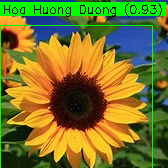

In [14]:
from ultralytics import YOLO
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from google.colab import files
import os

# Chọn nhiều ảnh từ máy
uploaded = files.upload()

# Load mô hình đã huấn luyện
model_path = "/content/drive/MyDrive/dataset_hoa/my_model/custom_train5/weights/best.pt"
model = YOLO(model_path)

# Tạo thư mục lưu kết quả
os.makedirs("predicted_results", exist_ok=True)

# Nếu bạn đã gán label tiếng Việt trong data.yaml thì YOLO sẽ tự dùng luôn
custom_labels = {
    15: 'Hoa Hai Duong',
    16: 'hoa Hong Do',
    17: 'Hoa Hong Phan',
    18: 'Hoa Huong Duong',
    19: 'Hoa Hong Nhat'
}

# Duyệt qua từng ảnh
for image_name in uploaded.keys():
    image = cv2.imread(image_name)
    results = model.predict(image, conf=0.6)

    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cls_id = int(box.cls[0])
            confidence = float(box.conf[0])

            label = custom_labels.get(cls_id, f"Class {cls_id}")
            text = f"{label} ({confidence:.2f})"

            # Font size nhỏ lại, phù hợp box
            font_scale = 0.4
            font_thickness = 1
            color = (0, 255, 0)

            # Vẽ box
            cv2.rectangle(image, (x1, y1), (x2, y2), color, 1)

            # Tính kích thước nhãn
            text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness)[0]
            text_w, text_h = text_size

            # Vị trí nhãn không đè đối tượng
            text_x = x1
            text_y = y1 - 10 if y1 - 10 > 10 else y1 + 10

            # Nền cho nhãn
            cv2.rectangle(image, (text_x, text_y - text_h - 4),
                          (text_x + text_w + 4, text_y), color, -1)

            # Ghi nhãn
            cv2.putText(image, text, (text_x + 2, text_y - 2),
                        cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 0), font_thickness)

    # Hiển thị ảnh
    print(f"Kết quả cho ảnh: {image_name}")
    cv2_imshow(image)

    # Lưu ảnh kết quả
    result_path = f"predicted_results/result_{image_name}"
    cv2.imwrite(result_path, image)

# Tạo link tải ảnh về
#!zip -r predicted_results.zip predicted_results
#files.download("predicted_results.zip")


In [14]:
!pip install -q gradio
import gradio as gr


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 96.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.4 MB/s eta 0:00:00


In [ ]:
import os

model_path = "/content/drive/MyDrive/dataset_hoa/my_model/custom_train4/weights/best.pt"

if os.path.exists(model_path):
    print("File tồn tại.")
else:
    print("File không tồn tại. Kiểm tra lại đường dẫn.")


File tồn tại.
